# PAPERMILL

In [1]:
# model's seeds
SEED = 0
# additional paramters
MODEL_PARAMETER_NAME = 'ccn+'
UNS_PARAMETER_PERCENTAGE = 1.0
NO_AUGMENTATIONS = False
GPU_ID = '1'
HIDE = '[]'

In [2]:
assert SEED is not None, "SEED should not be None"
assert MODEL_PARAMETER_NAME is not None, "MODEL_PARAMETER_NAME should not be None"
assert isinstance(UNS_PARAMETER_PERCENTAGE, float), "UNS_PARAMETER_PERCENTAGE should be a float"
assert 0.0 <= UNS_PARAMETER_PERCENTAGE <= 1.0, "UNS_PARAMETER_PERCENTAGE should be in the range [0.0, 1.0]"
assert GPU_ID is not None, "GPU_ID should not be None"

print("Papermill model name is: " + MODEL_PARAMETER_NAME)
print("Papermill uns_parameter_percentage is: " + str(UNS_PARAMETER_PERCENTAGE))
print("Papermill GPU_ID is: " + GPU_ID)

Papermill model name is: ccn+
Papermill uns_parameter_percentage is: 1.0
Papermill GPU_ID is: 1


# IMPORTS

In [3]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders


print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [4]:
import ast
import torch
import torch.nn as nn
import argparse
import datetime
import setproctitle, socket, uuid
import torch.nn.functional as F
import numpy as np
import random

from tqdm import tqdm
from argparse import Namespace
from numpy import float32, zeros
from datasets import get_dataset
from models import get_model
from models.mnistdpl import MnistDPL
from warmup_scheduler import GradualWarmupScheduler
from datasets.utils.base_dataset import BaseDataset
from torchvision import datasets, transforms
from torch.nn.modules import Module

from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from utils import fprint
from utils.train import train
from utils.test import test
from utils.preprocess_resnet import preprocess
from utils.conf import *
from utils.args import *
from utils.status import progress_bar
from utils.checkpoint import save_model, create_load_ckpt
from utils.dpl_loss import ADDMNIST_DPL
from utils.metrics import evaluate_metrics

from scipy.spatial.distance import cdist

from protonet_mnist_add_modules.arguments import args_sl, args_ltn, args_dpl, args_ccn
from protonet_mnist_add_modules.utility_modules.proto_utils import init_dataloader
    
from protonet_mnist_add_modules.data_modules.proto_data_creation import (
    choose_initial_prototypes,
    get_original_support_query_set,
    get_augmented_support_query_set,
    get_augmented_support_query_loader
)
from backbones.addmnist_protonet import PrototypicalLoss
from backbones.addmnist_protonet import initialize_unknown_prototypes_with_noise, compute_variance

from protonet_mnist_add_modules.utility_modules.check_gpu import my_gpu_info

# SETUP

In [5]:
MODEL = MODEL_PARAMETER_NAME
UNS_PERCENTAGE = UNS_PARAMETER_PERCENTAGE

print("Model is: " + MODEL)
print("Uns percentage is: " + str(UNS_PERCENTAGE))

Model is: ccn+
Uns percentage is: 1.0


In [6]:
if MODEL == 'sl':       args = args_sl
elif MODEL == 'ltn':    args = args_ltn
elif MODEL == 'dpl':    args = args_dpl
else:                   args = args_ccn

args.seed = SEED
print("Seed: " + str(args.seed))

# logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()
args.hide = ast.literal_eval(HIDE)

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

# saving
save_folder = "mnadd-even-odd" 
save_model_name = MODEL
save_path = os.path.join("..",
    "protonet-outputs-2", 
    save_folder, 
    "my_models", 
    save_model_name,
    f"episodic-proto-net-pipeline-{UNS_PERCENTAGE}-HIDE-{args.hide}"
)
print(f"Save paths: {str(save_path)}")

Seed: 0
Save paths: ../protonet-outputs-2/mnadd-even-odd/my_models/ccn+/episodic-proto-net-pipeline-1.0-HIDE-[]


In [7]:
my_gpu_info()

Torch version:  1.13.0+cu117
CUDA version:  11.7
Number of GPUs available: 1
Device 0: NVIDIA TITAN Xp
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


In [8]:
if args.model in ['mnistsl', 'mnistltn', 'mnistdpl', 'shieldedmnist'] or not args.prototypes:
    raise ValueError("This experiment is NOT meant for baseline models.")

# Utilities

In [9]:

# * for training data inspection
def plot_training_image(images, labels, plot_index_start=0, plot_index_end=10):
    for plotting_index in range(plot_index_start, plot_index_end + 1):
        image = images[plotting_index].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f"Label {labels[plotting_index]}")
        plt.axis('off')
        plt.show()

In [10]:

# * For prototypes computation at test phase 
def get_random_classes(images, labels, n_support, n_classes=10):
    unique_classes = torch.unique(labels)
    assert len(unique_classes) == n_classes, f"There should be exactly {n_classes} unique classes."
        
    selected_images = []
    selected_labels = []

    for cls in unique_classes:
        class_indices = (labels == cls).nonzero(as_tuple=True)[0]
        assert len(class_indices) >= n_support,\
            f"Not enough samples for class {cls}, needed {n_support}, but got {len(class_indices)}"
        random_indices = torch.randperm(len(class_indices))[:n_support]
        selected_images.append(images[class_indices[random_indices]])
        selected_labels.append(labels[class_indices[random_indices]])

    if n_classes > 0:
        selected_images = torch.cat(selected_images)
        selected_labels = torch.cat(selected_labels)
    else:
        selected_images = torch.empty((0, 1, 28, 28))
        selected_labels = torch.empty((0, 1), dtype=torch.long)

    return selected_images, selected_labels

# DATA

## Loading data for training the ProtoNet

In [11]:
args_protonet = Namespace(
    dataset=args.prototypical_dataset,     
    batch_size=args.prototypical_batch_size,
    preprocess=0,
    c_sup=1, # ^ supervision loaded to simulate direct annotation for prototypes
    which_c=[-1],
    model=args.model,        
    task=args.task,    
)

addmnist_dataset = get_dataset(args_protonet)
addmnist_train_loader, _ , _ = addmnist_dataset.get_data_loaders()
print(addmnist_dataset)

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loading train data
Loading val data
Loading test data


## Create (or get) the initial annotated images-prototype seed and augment it

In [12]:
if ( (not os.path.exists('data/prototypes/proto_loader_dataset.pth')) or args.debug ):
    choose_initial_prototypes(addmnist_train_loader, debug=args.debug)

tr_dataloader = init_dataloader()

support_images_aug, support_labels_aug, query_images_aug, query_labels_aug, no_aug = get_augmented_support_query_set(
    tr_dataloader, no_augmentations=NO_AUGMENTATIONS, debug=args.debug
)

# use the right digits in each pair (queries) to form the support set (2 elements)
if NO_AUGMENTATIONS:
    support_images_aug = torch.cat([support_images_aug, query_images_aug], dim=0)
    support_labels_aug = torch.cat([support_labels_aug, query_labels_aug], dim=0)
    assert support_images_aug.size() == torch.Size([20, 1, 28, 28]), f"support_images_aug size is {support_images_aug.size()}, expected [20, 1, 28, 28]"
    assert support_labels_aug.size() == torch.Size([20, 1]), f"support_labels_aug size is {support_labels_aug.size()}, expected [20, 1]"

support_loader, query_loader = get_augmented_support_query_loader(
    support_images_aug, 
    support_labels_aug, 
    query_images_aug, 
    query_labels_aug,
    query_batch_size=max(32, support_images_aug.size(0)),
    debug=args.debug
)

Number of rotations:  400
Number of translations:  1440
Number of scalings:  100
Number of elastic transformations:  250
Number of noising transformations:  40


## Dataset Creation

In [13]:
# Define an empty dataset
class EmptyDataset(Dataset):
    def __len__(self):
        return 0  # No samples

    def __getitem__(self, index):
        raise IndexError("This dataset is empty")

In [14]:
class MNISTAugDataset(Dataset):
    def __init__(self, images, labels, hide_labels=None, transform=None):
        # Store original dataset size
        self.original_length = labels.size(0)

        if hide_labels:
            # Create a boolean mask using torch.isin (available in recent versions of PyTorch)
            mask = ~torch.isin(labels, torch.tensor(hide_labels))
            # Use tensor indexing to filter both images and labels
            self.images = images[mask]
            self.labels = labels[mask]
            
            # Ensure the channel dimension is preserved
            if self.images.dim() == 3:  # If shape is [batch_filtered, 28, 28]
                self.images = self.images.unsqueeze(1)  # Add back the channel dim to get [batch_filtered, 1, 28, 28]
            if self.labels.dim() == 1:  # If shape is [batch_filtered]
                self.labels = self.labels.unsqueeze(1)  # Add back the channel dim to get [batch_filtered, 1]

            self.num_filtered = self.original_length - mask.sum().item()
        else:
            self.images = images
            self.labels = labels
            self.num_filtered = 0
        
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label.squeeze()

    def __len__(self):
        return len(self.labels)

# Example instantiation:
mnist_dataset = MNISTAugDataset(support_images_aug, support_labels_aug, hide_labels=args.hide)
assert all(lbl not in args.hide for lbl in mnist_dataset.labels), "mnist_dataset contains images with hidden labels"

## Creating the Episodes

In [15]:
class PrototypicalBatchSampler(object):
    '''
    PrototypicalBatchSampler: yield a batch of indexes at each iteration.
    Indexes are calculated by keeping in account 'classes_per_it' and 'num_samples',
    In fact at every iteration the batch indexes will refer to  'num_support' + 'num_query' samples
    for 'classes_per_it' random classes.

    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, labels, classes_per_it, num_samples, iterations):
        '''
        Initialize the PrototypicalBatchSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class (support + query)
        - iterations: number of iterations (episodes) per epoch
        '''
        super(PrototypicalBatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # create a matrix, indexes, of dim: classes X max(elements per class)
        # fill it with nans
        # for every class c, fill the relative row with the indices samples belonging to c
        # in numel_per_class we store the number of samples for each class/row
        self.idxs = range(len(self.labels))
        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.indexes = torch.Tensor(self.indexes)
        self.numel_per_class = torch.zeros_like(self.classes)
        for idx, label in enumerate(self.labels):
            label_idx = np.argwhere(self.classes == label).item()
            self.indexes[label_idx, np.where(np.isnan(self.indexes[label_idx]))[0][0]] = idx
            self.numel_per_class[label_idx] += 1

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        spc = self.sample_per_class
        cpi = self.classes_per_it

        for it in range(self.iterations):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                # FIXME when torch.argwhere will exists
                label_idx = torch.arange(len(self.classes)).long()[self.classes == c].item()
                sample_idxs = torch.randperm(self.numel_per_class[label_idx])[:spc]
                batch[s] = self.indexes[label_idx][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations

In [16]:
original_labels = support_labels_aug.squeeze().numpy()
labels = mnist_dataset.labels.squeeze().numpy()
num_distinct_labels = np.unique(labels).size
print(f"Number of distinct labels: {num_distinct_labels}")

assert labels.size == original_labels.size - mnist_dataset.num_filtered, \
    "The number of elements in labels should be the number of elements in original_labels minus the number of filtered elements"    
assert isinstance(labels, np.ndarray), "labels should be a numpy.ndarray"
assert mnist_dataset.images.shape == (labels.size, 1, 28, 28), \
    "The shape of mnist_dataset.images should be (number of labels, 1, 28, 28)"
assert mnist_dataset.labels.shape == (labels.size, 1), \
    "The shape of mnist_dataset.labels should be (number of labels, 1)"

Number of distinct labels: 10


In [17]:
print(support_labels_aug.shape)
print(mnist_dataset.labels.shape)

torch.Size([2230, 1])
torch.Size([2230, 1])


In [18]:
num_support = args.num_support
num_query = args.num_query
num_samples = args.num_samples
classes_per_it = args.classes_per_it
iterations = args.iterations


print("Classes in dataset:", np.unique(labels))
episodic_dataloader = DataLoader(EmptyDataset(), batch_size=1)
if classes_per_it > 0:
    sampler = PrototypicalBatchSampler(labels, classes_per_it, num_samples, iterations)
    episodic_dataloader = DataLoader(mnist_dataset, batch_sampler=sampler)

Classes in dataset: [0 1 2 3 4 5 6 7 8 9]


## Checking the Episodes

Batch images shape: torch.Size([50, 1, 28, 28])
Batch labels: [5, 2, 1, 5, 2, 3, 4, 4, 1, 1, 1, 2, 4, 5, 1, 2, 4, 3, 5, 5, 2, 4, 1, 2, 3, 5, 1, 3, 5, 5, 2, 2, 4, 5, 3, 3, 2, 3, 5, 1, 1, 3, 3, 4, 4, 3, 4, 4, 2, 1]
Label distribution in batch: Counter({5: 10, 2: 10, 1: 10, 3: 10, 4: 10})


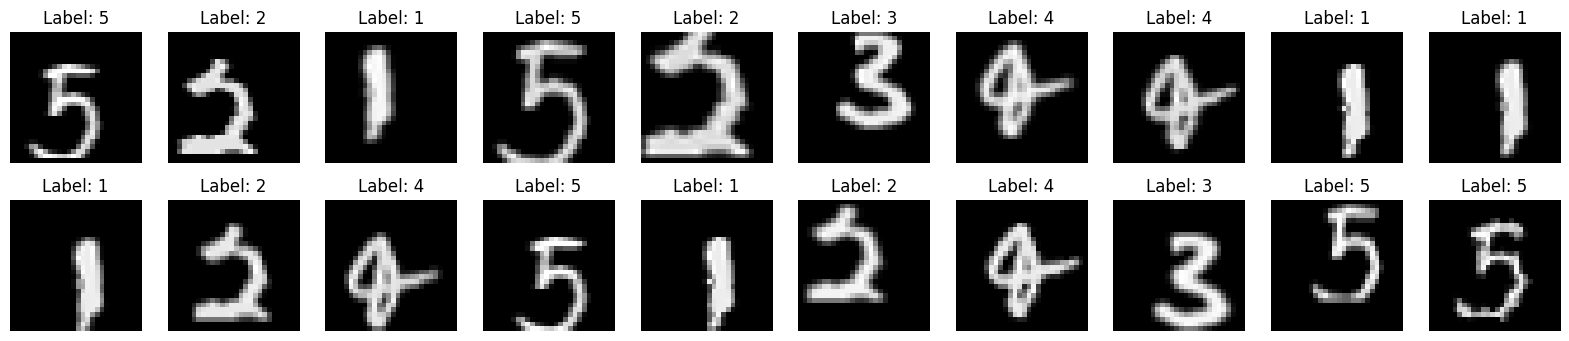

In [19]:
if classes_per_it > 0:
    for batch in episodic_dataloader:
        images, labels = batch
        labels = labels.tolist()
        label_counts = Counter(labels)  # Count occurrences of each label
        
        print("Batch images shape:", images.shape)  # Should be [batch_size, 1, 28, 28] for MNIST
        print("Batch labels:", labels)  # Check if labels are grouped correctly per class
        print("Label distribution in batch:", label_counts)
        break  # Only inspect one batch

    # Plot the first 10 images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    if len(args.hide) > 0 or NO_AUGMENTATIONS:
        min_images = min(20, num_support + num_query)
    else:
        min_images = 20
    for i in range(min_images):
        ax = axes[i // 10, i % 10]
        ax.imshow(images[i][0], cmap="gray")  # MNIST is grayscale
        ax.set_title(f"Label: {labels[i]}")
        ax.axis("off")

    plt.show()

## Getting the Unsupervised Dataset

In [20]:
dataset = get_dataset(args)
print(dataset)

n_images, c_split = dataset.get_split()
encoder, decoder = dataset.get_backbone()
if encoder.unknown_prototypes is not None:
    assert encoder.unknown_prototypes.size(0) == len(args.hide), \
        "The number of hidden labels should match the number of unknown prototypes"
model = get_model(args, encoder, decoder, n_images, c_split)
loss = model.get_loss(args)

print("Using Dataset: ", dataset)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)

unsup_train_loader, unsup_val_loader, _ = dataset.get_data_loaders()
dataset.print_stats()

if hasattr(model, "start_optim"):
    print("Starting model's own optimizer.")
    model.start_optim(args)

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
[BACKBONE-INFO] Using Prototypical Networks as backbone
Available models: ['promnistltn', 'promnmathcbm', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'kandslsingledisj', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'kandltnsinglejoint', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'kanddplsinglejoint', 'xordpl', 'promnmathdpl', 'bddoiadpldisj', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'shieldedmnist', 'kandltnsingledisj', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm

## Checking the Unsupervised Data

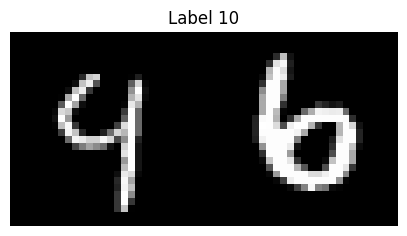

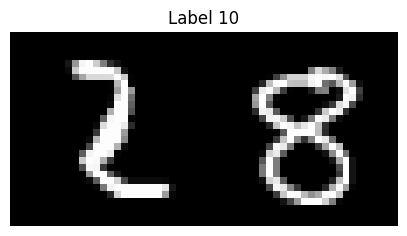

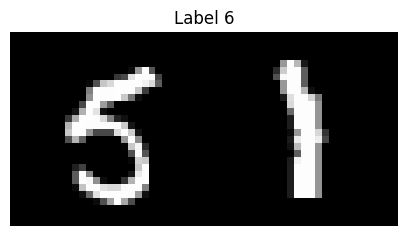

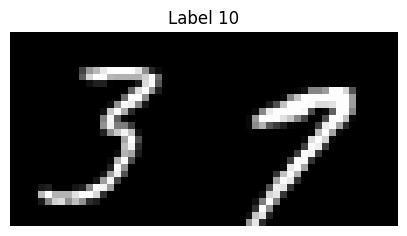

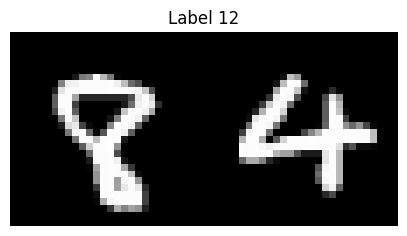

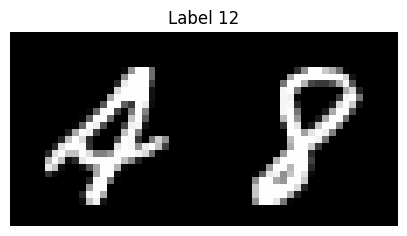

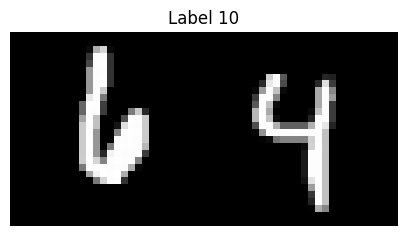

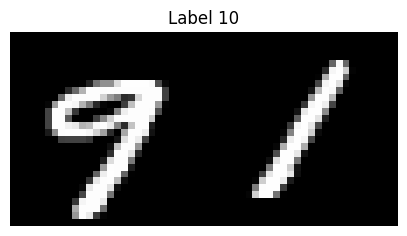

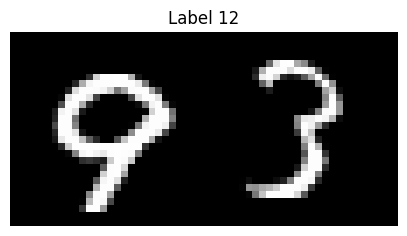

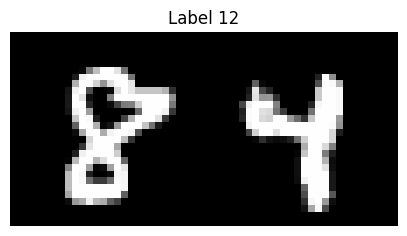

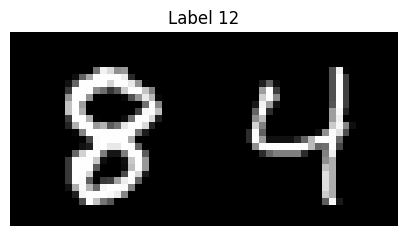

In [22]:
for i, data in enumerate(unsup_train_loader):
    images, labels, concepts = data        
    plot_training_image(images, labels)
    break

# Training

## Main Loop

In [24]:
def train(model:MnistDPL,
        encoder:Module,
        episodic_dataloader:DataLoader,
        unsup_train_loader:DataLoader,
        unsup_val_loader:DataLoader,
        _loss: ADDMNIST_DPL, 
        args,
        seed,
        save_folder):
    
    # for full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False
    
    # for early stopping
    best_f1 = 0.0
    epochs_no_improve = 0

    # model configuration for shortmnist
    if args.dataset == "shortmnist":    model = model.float()

    # device configuration
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize the optimizer and the scheduler.
    optimizer = torch.optim.Adam(encoder.parameters())
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    proto_train_loss_history = []
    proto_train_acc_history = []

    fprint("\n--- Start of Training ---\n")
    for epoch in range(args.proto_epochs):
        print(f"Epoch {epoch+1}/{args.proto_epochs}")
        print("--- Training Protonet")
        encoder.train()

        epoch_loss = []
        epoch_acc = []
        # ^ PHASE 1: Training the Protonet with the episodic dataloader
        for batch in tqdm(episodic_dataloader, total=args.iterations):
            optimizer.zero_grad()
            
            # Get batch images and labels
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass: compute embeddings for all images in the episode.
            embeddings = encoder(images)
            
            # Compute prototypical loss.
            pNet_loss = PrototypicalLoss(n_support=args.num_support)
            loss, acc = pNet_loss(input=embeddings, target=labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss.append(loss.item())
            epoch_acc.append(acc.item())
        
        avg_loss = np.mean(epoch_loss)
        avg_acc = np.mean(epoch_acc)
        proto_train_loss_history.append(avg_loss)
        proto_train_acc_history.append(avg_acc)
        
        print(f"  Avg Loss: {avg_loss:.4f} | Avg Acc: {avg_acc:.4f}")

        # ^ PHASE 2: Training the Protonet with the unsupervised dataloader
        print("--- Training with Unsupervised Data")

        # ys are the predictions of the model, y_true are the true labels, cs are the predictions of the concepts, cs_true are the true concepts
        ys, y_true, cs, cs_true = None, None, None, None
        
        unknown_init = True if (len(args.hide) > 0) else False
        for i,data in enumerate(unsup_train_loader):
            if random.random() > UNS_PERCENTAGE:
                continue  # Skip this batch with probability (1 - percentage)

            if hasattr(model, "opt") and model.opt is not None:
                model.opt.zero_grad()
            else:
                optimizer.zero_grad()

            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),    # input IMAGES
                labels.to(model.device),    # ground truth LABELS
                concepts.to(model.device),  # ground truth CONCEPTS
            )

            # Get a random support set.
            this_support_images, this_support_labels = get_random_classes(
                mnist_dataset.images, mnist_dataset.labels, args.n_support, num_distinct_labels)
            assert this_support_images.shape == (args.n_support * num_distinct_labels, 1, 28, 28), \
                f"Support images shape is not ({args.n_support * num_distinct_labels}, 1, 28, 28), but {this_support_images.shape}"
            assert this_support_labels.shape == (args.n_support * num_distinct_labels, 1), \
                f"Support labels shape is not ({args.n_support * num_distinct_labels}, 1), but {this_support_labels.shape}"
            
        
            out_dict = model(images, this_support_images, this_support_labels, unknown_init=unknown_init)
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})
            unknown_init = False

            loss, losses = _loss(out_dict, args)
            loss.backward()

            if hasattr(model, "opt") and model.opt is not None:
                model.opt.step()
            else:
                optimizer.step()

            if args.debug: print("[DEBUG]: ", model.unknown_prototypes.grad)
            
            if ys is None:  # first iteration
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:           # all other iterations
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(unsup_train_loader) - 9, epoch, loss.item())

        
        # Step the scheduler (if using)
        lr_scheduler.step()

        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("End of epoch ", epoch)
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print()

        # ^ PHASE 3: Evaluation
        if ys is None:  
            torch.save(model.state_dict(), save_folder)
            print(f"Saved model after prototypical netwrork training.")
            print()
            continue  # Skip evaluation if no unsupervised data was used
        
        y_pred = torch.argmax(ys, dim=-1)
        # Get a random support set.
        this_support_images, this_support_labels = get_random_classes(
            mnist_dataset.images, mnist_dataset.labels, args.n_support, num_distinct_labels)
        assert this_support_images.shape == (args.n_support * num_distinct_labels, 1, 28, 28), \
            f"Support images shape is not ({args.n_support * num_distinct_labels}, 1, 28, 28), but {this_support_images.shape}"
        assert this_support_labels.shape == (args.n_support * num_distinct_labels, 1), \
            f"Support labels shape is not ({args.n_support * num_distinct_labels}, 1), but {this_support_labels.shape}"
        
        model.eval()
        tloss, cacc, yacc, f1 = evaluate_metrics(model, unsup_val_loader, args, support_images=this_support_images, support_labels=this_support_labels)

        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1)
        print()

        if f1 > best_f1:
            print("Saving...")
            # Update best F1 score
            best_f1 = f1
            epochs_no_improve = 0

            # Save the best model
            torch.save(model.state_dict(), save_folder)
            print(f"Saved best model with F1 score: {best_f1}")
            print()
        
        elif f1 <= best_f1:
            epochs_no_improve += 1

        if epochs_no_improve >= args.patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("End of training")
    return best_f1

## Running

In [25]:
f1_scores = dict()
print(f"*** Training model with seed {SEED}")
print("Chosen device:", model.device)
print("Save path for this model: ", save_path)
if not os.path.exists(save_path): os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{save_model_name}_{args.seed}.pth")
print("Saving in folder: ", save_folder)

best_f1 = train(model=model,
    encoder=encoder,
    episodic_dataloader=episodic_dataloader,
    unsup_train_loader=unsup_train_loader,
    unsup_val_loader=unsup_val_loader,
    _loss=loss, 
    args=args,
    seed=args.seed,
    save_folder=save_folder
)
save_model(model, args, args.seed)  # save the model parameters

print(f"Best F1 score: {best_f1}")

*** Training model with seed 0
Chosen device: cuda
Save path for this model:  ../protonet-outputs-2/mnadd-even-odd/my_models/ccn+/episodic-proto-net-pipeline-1.0-HIDE-[]
Saving in folder:  ../protonet-outputs-2/mnadd-even-odd/my_models/ccn+/episodic-proto-net-pipeline-1.0-HIDE-[]/ccn+_0.pth

--- Start of Training ---

Epoch 1/10
--- Training Protonet


100%|██████████| 100/100 [00:02<00:00, 40.74it/s]

  Avg Loss: 0.1832 | Avg Acc: 0.9616
--- Training with Unsupervised Data


Custom ordering for shield: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
Using auto mode ::: Detected propositional requirements!
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f91c4c3aa90>]
head 38 with old rules 1
head 38 with new rules 1
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f91c4c3acd0>, <pishield.propositional_requirements.constraint.Constraint object at 0x7f91c4c3adf0>]
head 37 with old rules 2
head 37 with new rules 3
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f91c59890d0>, <pishield.propositional_requirements.constraint.Constraint object at 0x7f91c59891f0>, <pishield.propositional_requirements.constraint.Constraint object at 0x7f91c5989310>]
head 36 with old rules 3
head 36 with new rules 5
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f91c5989700>, <pishield.propositional_requirements.con

[ 10-06 | 08:01 ] epoch 0: |██████████████████████████████████████████████████| loss: 0.12145891

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 93.22916666666667 F1 Y 72.66277857656141

Saving...
Saved best model with F1 score: 72.66277857656141

Epoch 2/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 61.77it/s]


  Avg Loss: 0.1095 | Avg Acc: 0.9848
--- Training with Unsupervised Data


[ 10-06 | 08:05 ] epoch 1: |██████████████████████████████████████████████████| loss: 0.03945684

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 96.82291666666667 F1 Y 81.79377737692408

Saving...
Saved best model with F1 score: 81.79377737692408

Epoch 3/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.09it/s]


  Avg Loss: 0.0731 | Avg Acc: 0.9888
--- Training with Unsupervised Data


[ 10-06 | 08:09 ] epoch 2: |██████████████████████████████████████████████████| loss: 0.06698029

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.70833333333333 F1 Y 87.18869957539094

Saving...
Saved best model with F1 score: 87.18869957539094

Epoch 4/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.18it/s]


  Avg Loss: 0.0406 | Avg Acc: 0.9940
--- Training with Unsupervised Data


[ 10-06 | 08:13 ] epoch 3: |██████████████████████████████████████████████████| loss: 0.03070227

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.96875 F1 Y 87.01483551229859

Epoch 5/10
--- Training Protonet


100%|██████████| 100/100 [00:02<00:00, 49.68it/s]


  Avg Loss: 0.0315 | Avg Acc: 0.9948
--- Training with Unsupervised Data


[ 10-06 | 08:17 ] epoch 4: |██████████████████████████████████████████████████| loss: 0.04763915

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.23958333333333 F1 Y 83.03500003444215

Epoch 6/10
--- Training Protonet


100%|██████████| 100/100 [00:02<00:00, 47.98it/s]


  Avg Loss: 0.0191 | Avg Acc: 0.9972
--- Training with Unsupervised Data


[ 10-06 | 08:21 ] epoch 5: |██████████████████████████████████████████████████| loss: 0.00175689

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.54166666666667 F1 Y 92.01360987334279

Saving...
Saved best model with F1 score: 92.01360987334279

Epoch 7/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 58.22it/s]


  Avg Loss: 0.0230 | Avg Acc: 0.9952
--- Training with Unsupervised Data


[ 10-06 | 08:25 ] epoch 6: |██████████████████████████████████████████████████| loss: 0.00065203

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.91666666666667 F1 Y 89.5141656578856

Epoch 8/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.41it/s]


  Avg Loss: 0.0280 | Avg Acc: 0.9948
--- Training with Unsupervised Data


[ 10-06 | 08:29 ] epoch 7: |██████████████████████████████████████████████████| loss: 0.00166446

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.02083333333333 F1 Y 89.91327179711583

Epoch 9/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 62.20it/s]


  Avg Loss: 0.0220 | Avg Acc: 0.9976
--- Training with Unsupervised Data


[ 10-06 | 08:33 ] epoch 8: |██████████████████████████████████████████████████| loss: 0.00027923

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.125 F1 Y 92.67932678864825

Saving...
Saved best model with F1 score: 92.67932678864825

Epoch 10/10
--- Training Protonet


100%|██████████| 100/100 [00:01<00:00, 60.69it/s]


  Avg Loss: 0.0232 | Avg Acc: 0.9964
--- Training with Unsupervised Data


[ 10-06 | 08:37 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.00034391

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.4375 F1 Y 92.0642236062462

End of training
Best F1 score: 92.67932678864825
